In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint
import process_utility as psu
import scipy.integrate as integ
from scipy.optimize import curve_fit
import time
import math

In [73]:
def process_abalone_data(data,nn=1000,nplot=5,width_calc=False):
    print(f'Total events number: {len(data)}')
    MINs, FOMs, MAXs, INTs, width50, FWHMs = [], [], [], [], [], []
    ts = time.time()
    plt.figure(figsize=(12,6))
    if nn == 0: nn = len(data)
    for i in range(nn):
        if (i % 50000) == 0: print(f'event n. {i} time to process: {time.time()-ts:.2f}')
        bl=np.max(data[i][:])
        wf = bl-data[i]
        max_pos = np.where(wf==np.max(wf))[0][0]
        area = np.sum(wf)
        fom = np.sum(wf[max_pos:])/area
        MINs.append(bl)
        MAXs.append(np.max(wf))
        FOMs.append(fom)
        INTs.append(area)
        fwhm = np.where(wf>np.max(wf)*0.5)[0][-1]-np.where(wf>np.max(wf)*0.5)[0][0]
        FWHMs.append(fwhm)
        if width_calc:
            ii, areafrac = 1, 0
            while areafrac < 0.5:
                ilo50, ihi50 = max_pos-ii, max_pos+ii
                areafrac = np.sum(wf[ilo50:ihi50])/area
                ii += 1
                wid50 = ihi50 - ilo50
            width50.append(wid50)
            if i < nplot: plt.plot(wf,label=f'A={area}, width={wid50}')
        else:
            if i < nplot: plt.plot(wf,label=f'A={area}, f.o.m.={fom:.2f}, fwhm={fwhm}')
    plt.legend()
    return np.array(MINs), np.array(FOMs), np.array(MAXs),np.array(INTs),np.array(width50),np.array(FWHMs)

Total events number: 735537
event n. 0 time to process: 0.00


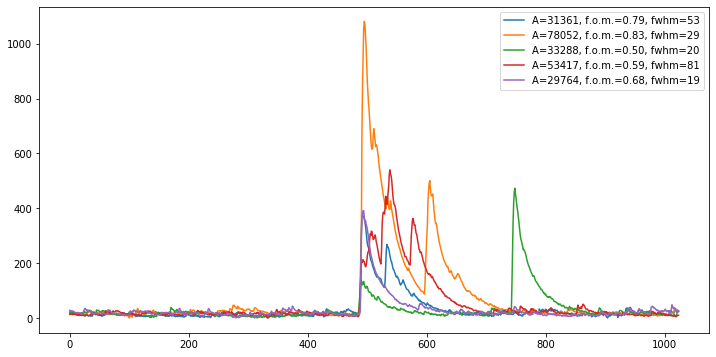

In [74]:
#data = psu.read_file('/data/abalone/2021_05_07/SiPM2_32V_ABALONE_12k_NoLED.dat')
MINs, FOMs, MAXs, INTs, width50, FWHMs = process_abalone_data(data,nn=100,nplot=5)

# ABALONE at 5 kV

In [3]:
data5k = psu.read_file('/data/abalone/2021_05_07/SiPM2_32V_ABALONE_5k_NoLED.dat')
data5k_LED = psu.read_file('/data/abalone/2021_05_07/SiPM2_32V_ABALONE_5k_LED_3V.dat')

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_5k_NoLED.dat Number of events 43236.0
/data/abalone/2021_05_07/SiPM2_32V_ABALONE_5k_LED_3V.dat Number of events 58162.0


Total events number: 43236
event n. 0 time to process: 0.00
Total events number: 58162
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.45


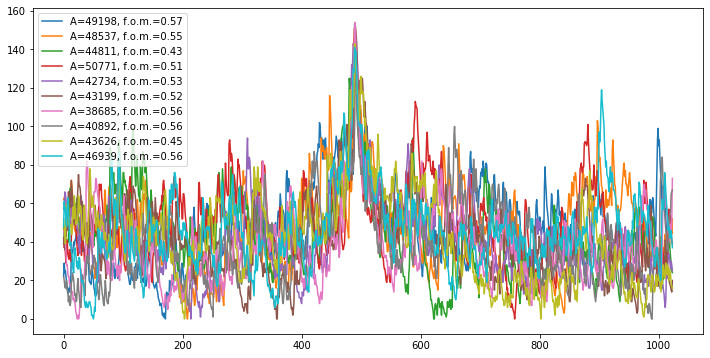

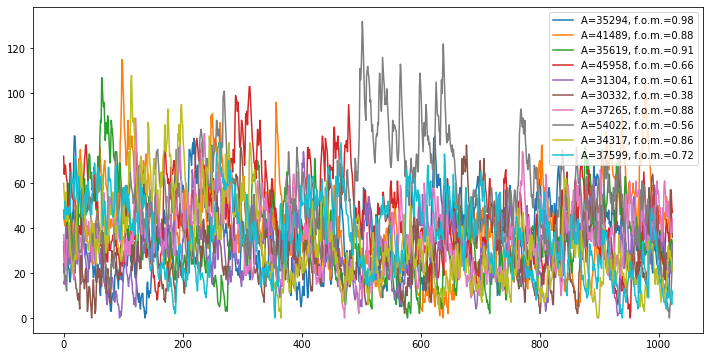

In [10]:
MINs, FOMs, MAXs, INTs, width50 = process_abalone_data(data5k,nn=0,nplot=10)
MINsL, FOMsL, MAXsL, INTsL, width50L = process_abalone_data(data5k_LED,nn=0,nplot=10)

In [7]:
def plot_hist1D(MINs,MAXs,FOMs,AREAs,width50,bins=200):
    area_space = np.logspace(3.5,7, bins)
    width_space = np.logspace(1,3.5, bins)
    max_space = np.linspace(0,15000,bins)

    plt.figure(figsize=(12,6))
    a=plt.hist(MINs,range=(14700,14800),bins=100)
    plt.yscale('log')
    plt.title('MIN POSITION')
    plt.xlabel('ADC channels',ha='right',x=1)
    plt.ylabel('counts',ha='right',y=1)

    plt.figure(figsize=(12,6))
    a=plt.hist(MAXs,range=(0,2000),bins=100)
    plt.yscale('log')
    plt.title('MAX POSITION')
    plt.xlabel('ADC channels',ha='right',x=1)
    plt.ylabel('counts',ha='right',y=1)

    plt.figure(figsize=(12,6))
    a=plt.hist(FOMs,bins=100)
    plt.yscale('log')
    plt.title('F.O.M.')
    plt.xlabel('F.O.M.',ha='right',x=1)
    plt.ylabel('counts',ha='right',y=1)

    plt.figure(figsize=(12,6))
    a=plt.hist(AREAs,bins=300,range=(0,3e6))
    plt.yscale('log')
    plt.title('Total Integral')
    plt.xlabel('area',ha='right',x=1)
    plt.ylabel('counts',ha='right',y=1)

    plt.figure(figsize=(12,6))
    a=plt.hist(width50,bins=300)
    plt.yscale('log')
    plt.title('width 50%')
    plt.xlabel('width 50%',ha='right',x=1)
    plt.ylabel('counts',ha='right',y=1)

In [77]:
def plot_area_max(AREAs,MAXs,bins=200,volts=10):
    area_space = np.logspace(3.5,7, bins)
    max_space = np.logspace(1,4.5,bins)
    plt.figure(figsize=(12,6))
    a=plt.hist2d(AREAs,MAXs,bins=(area_space,max_space),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('area (chn)',ha='right',x=1,fontsize=12)
    plt.ylabel('peak max (chn)',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} V')
    
def plot_area_fom(AREAs,FOMs,bins=200,volts=10):
    area_space = np.logspace(3.5,7, bins)
    plt.figure(figsize=(12,6))
    a=plt.hist2d(AREAs,FOMs,bins=(area_space,bins),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.xlabel('area',ha='right',x=1,fontsize=12)
    plt.ylabel('FOM',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} V')
    
def plot_area_width(AREAs,width50,bins=200,volts=10):
    area_space = np.logspace(3.5,7, bins)
    width_space = np.logspace(1,3.5, bins)
    plt.figure(figsize=(12,6))
    a=plt.hist2d(AREAs,width50,bins=(area_space,width_space),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('area',ha='right',x=1,fontsize=12)
    plt.ylabel('width 50%',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} V')

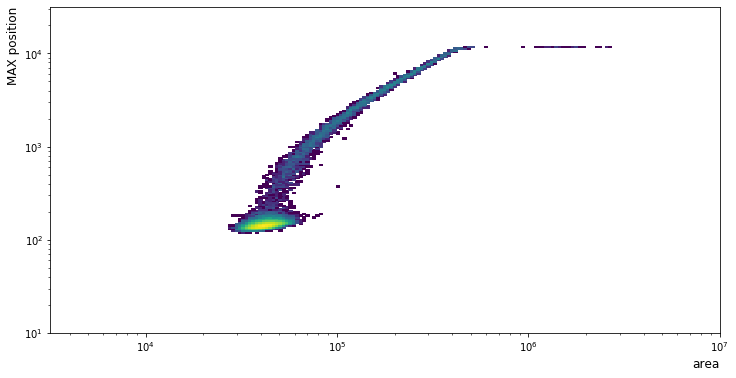

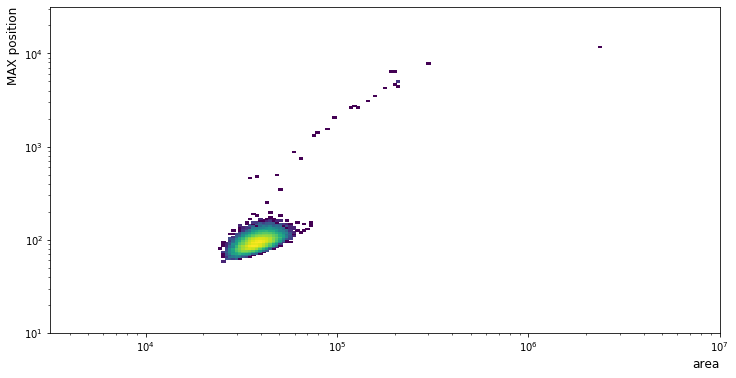

In [9]:
plot_area_max(INTs,MAXs,bins=200)
plot_area_max(INTsL,MAXsL,bins=200)

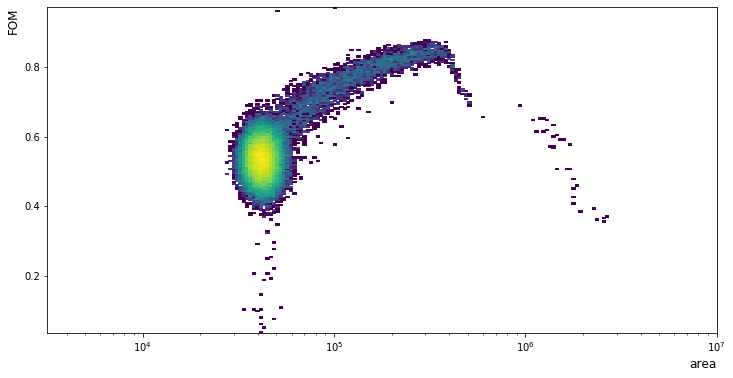

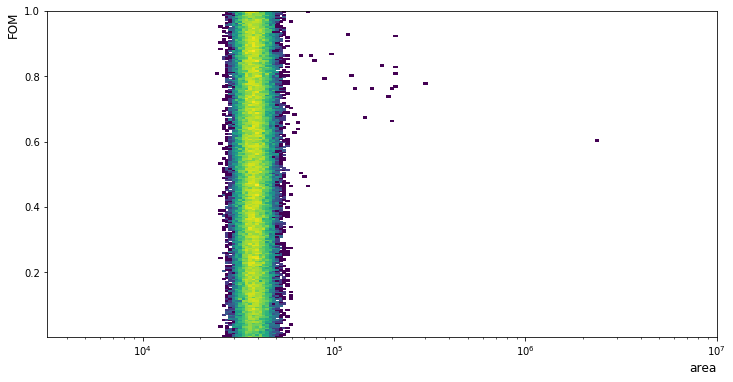

In [10]:
plot_area_fom(INTs,FOMs,bins=200)
plot_area_fom(INTsL,FOMsL,bins=200)

In [12]:
#plot_area_width(INTs,width50,bins=200)
#plot_area_width(INTs[MAXs>100],width50[MAXs>100],bins=200)

# ABALONE at 10 kV - 07/05/2021 12:00

In [13]:
data10k = psu.read_file('/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_noLED.dat')
data10k_LED = psu.read_file('/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED_3V.dat')
data10k_LEDt = psu.read_file('/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED_threshold.dat')

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_noLED.dat Number of events 693594.0
/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED_3V.dat Number of events 57876.0
/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED_threshold.dat Number of events 735593.0


Total events number: 693594
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.59
event n. 100000 time to process: 3.13
event n. 150000 time to process: 4.67
event n. 200000 time to process: 6.20
event n. 250000 time to process: 7.74
event n. 300000 time to process: 9.28
event n. 350000 time to process: 10.82
event n. 400000 time to process: 12.36
event n. 450000 time to process: 13.89
event n. 500000 time to process: 15.43
event n. 550000 time to process: 16.96
event n. 600000 time to process: 18.51
event n. 650000 time to process: 20.07
Total events number: 57876
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.57
Total events number: 735593
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.56
event n. 100000 time to process: 3.10
event n. 150000 time to process: 4.63
event n. 200000 time to process: 6.18
event n. 250000 time to process: 7.72
event n. 300000 time to process: 9.26
event n. 350000 time to process: 10.80
event n. 400000

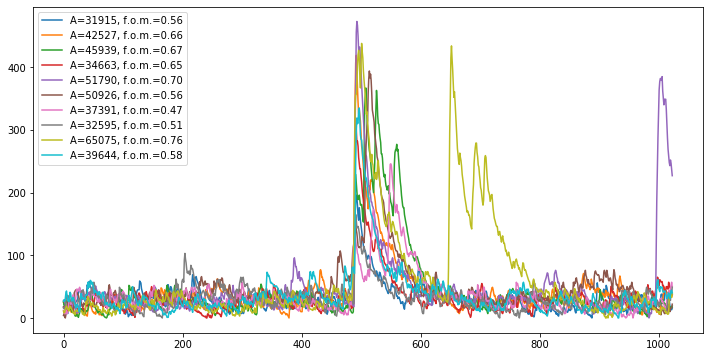

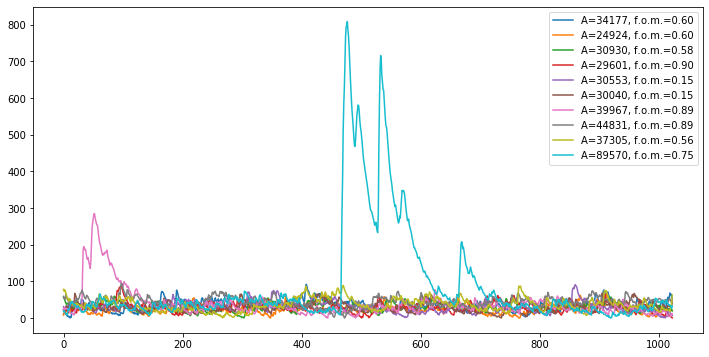

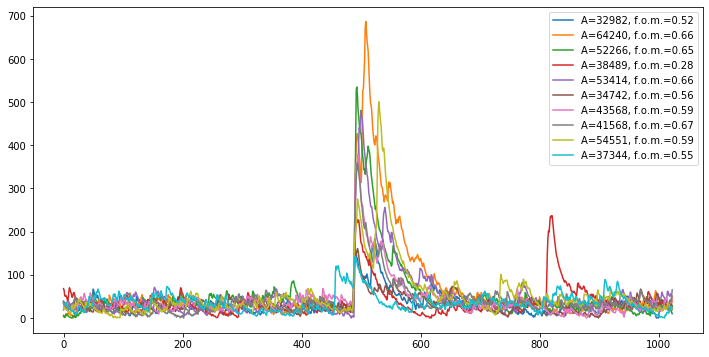

In [15]:
MINs_10, FOMs_10, MAXs_10, INTs_10, width50_10 = process_abalone_data(data10k,nn=0,nplot=10)
MINs_10L, FOMs_10L, MAXs_10L, INTs_10L, width50_10L = process_abalone_data(data10k_LED,nn=0,nplot=10)
MINs_10L, FOMs_10Lt, MAXs_10Lt, INTs_10Lt, width50_10Lt = process_abalone_data(data10k_LEDt,nn=0,nplot=10)

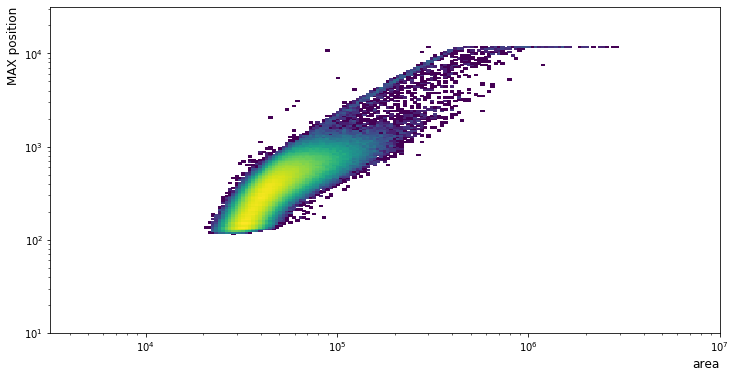

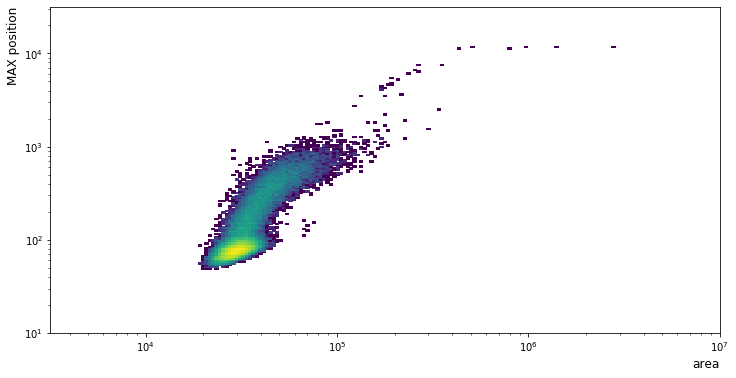

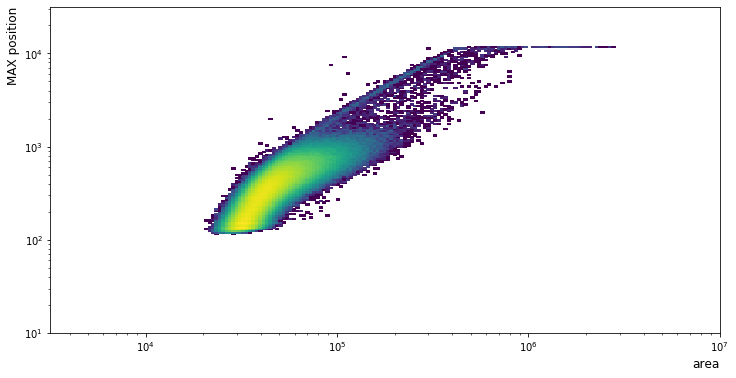

In [16]:
plot_area_max(INTs_10,MAXs_10,bins=200)
plot_area_max(INTs_10L,MAXs_10L,bins=200)
plot_area_max(INTs_10Lt,MAXs_10Lt,bins=200)

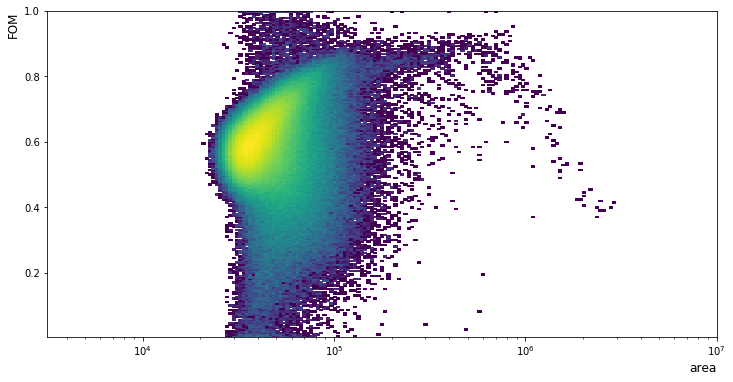

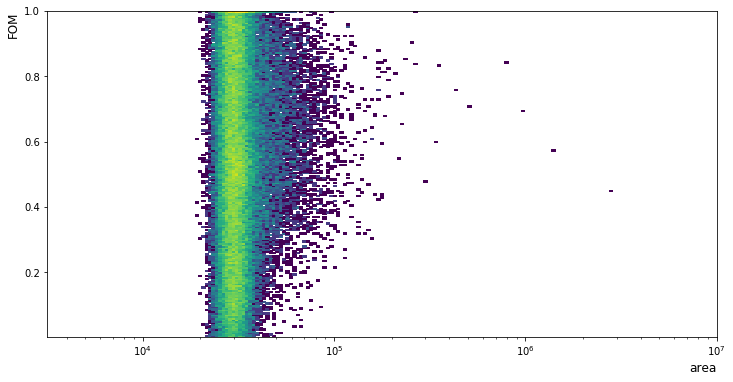

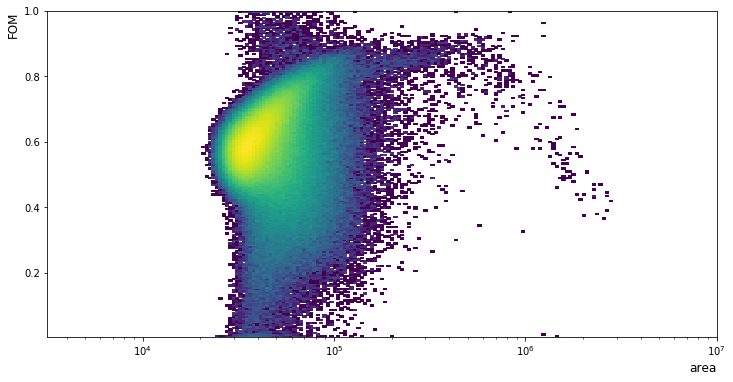

In [18]:
plot_area_fom(INTs_10,FOMs_10,bins=200)
plot_area_fom(INTs_10L,FOMs_10L,bins=200)
plot_area_fom(INTs_10Lt,FOMs_10Lt,bins=200)

# ABALONE at 10 kV - 07/05/2021 17:00

In [75]:
def data_analysis(filename='/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_noLED_h17.dat',volts=10):
    data = psu.read_file(filename)
    MINs, FOMs, MAXs, INTs, width50, FWHMs = process_abalone_data(data,nn=0,nplot=10)
    plot_area_max(INTs,MAXs,bins=200,volts=volts)
    plot_area_fom(INTs,FOMs,bins=200,volts=volts)
    plot_area_width(INTs,FWHMs,bins=200,volts=volts)

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_noLED_h17.dat Number of events 596383.0
Total events number: 596383
event n. 0 time to process: 0.00
event n. 50000 time to process: 2.61
event n. 100000 time to process: 5.17
event n. 150000 time to process: 7.75
event n. 200000 time to process: 10.32
event n. 250000 time to process: 12.90
event n. 300000 time to process: 15.48
event n. 350000 time to process: 18.05
event n. 400000 time to process: 20.62
event n. 450000 time to process: 23.20
event n. 500000 time to process: 25.77
event n. 550000 time to process: 28.34


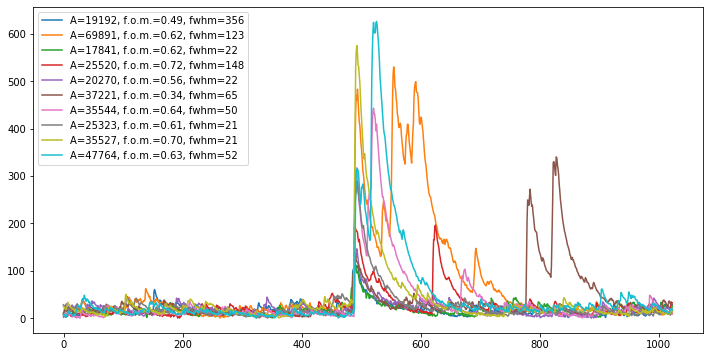

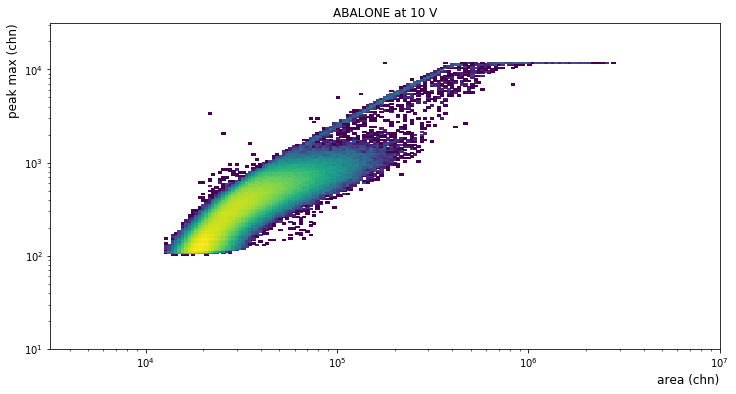

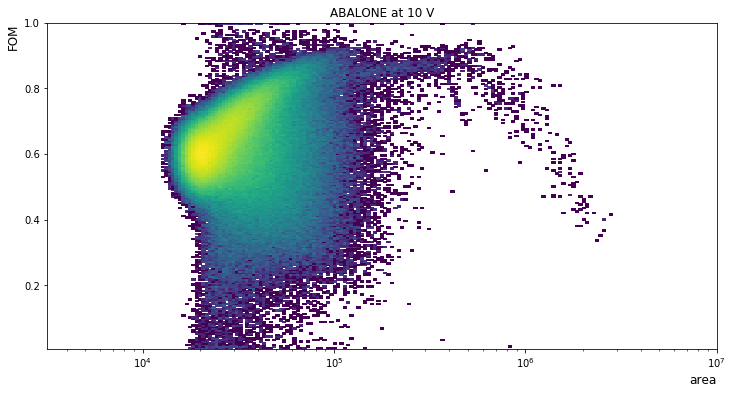

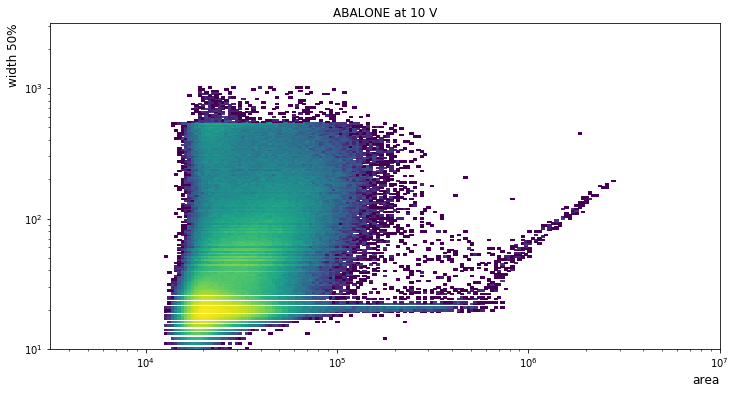

In [78]:
data_analysis(volts=10)

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED10V_h17_threshold.dat Number of events 576282.0
Total events number: 576282
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.54
event n. 100000 time to process: 3.10
event n. 150000 time to process: 4.66
event n. 200000 time to process: 6.22
event n. 250000 time to process: 7.78
event n. 300000 time to process: 9.34
event n. 350000 time to process: 10.89
event n. 400000 time to process: 12.46
event n. 450000 time to process: 14.02
event n. 500000 time to process: 15.58
event n. 550000 time to process: 17.14


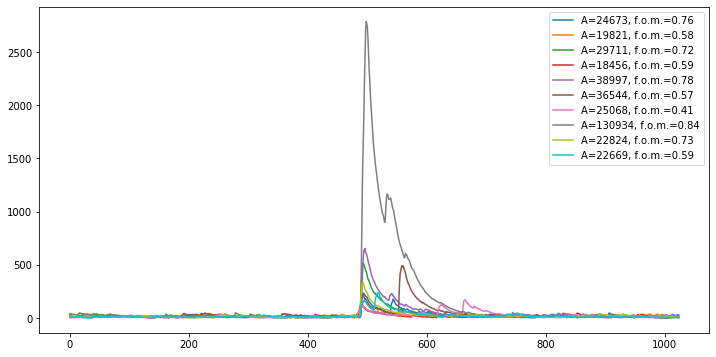

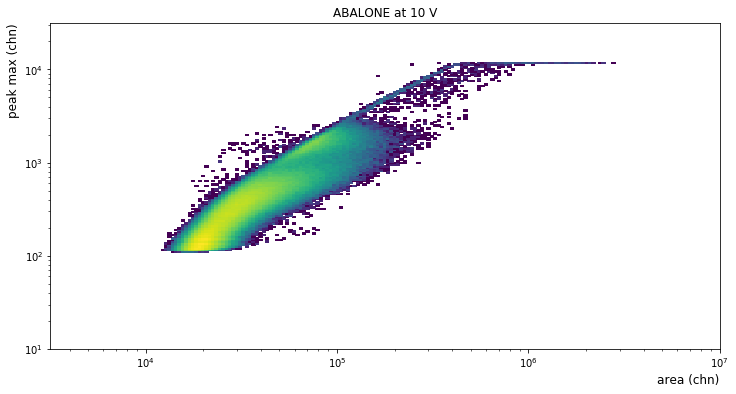

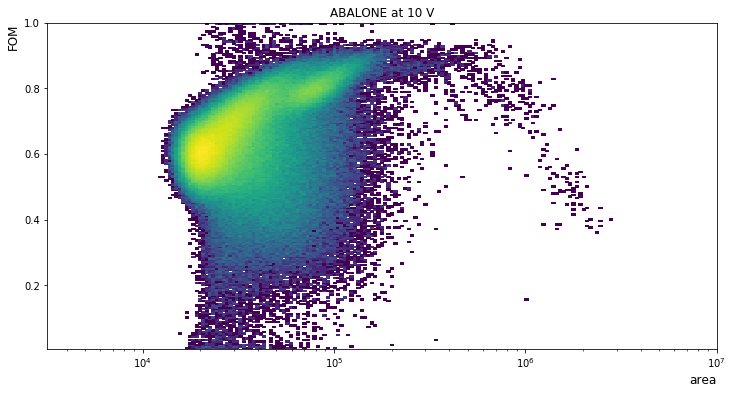

In [40]:
data_analysis(volts=10,filename='/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED10V_h17_threshold.dat')

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED10V_h17.dat Number of events 58191.0
Total events number: 58191
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.54


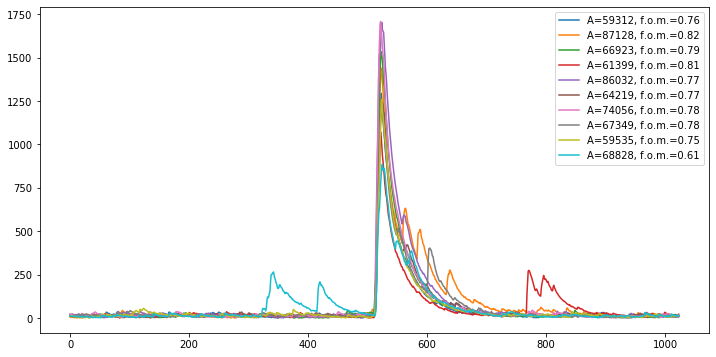

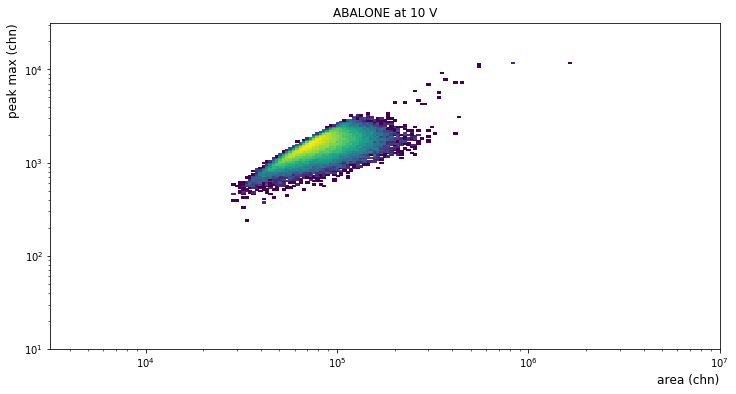

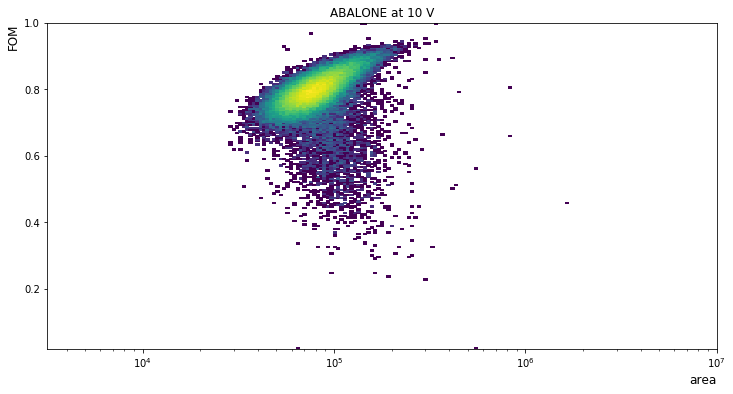

In [41]:
data_analysis(volts=10,filename='/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED10V_h17.dat')

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED4V_h17.dat Number of events 58014.0
Total events number: 58014
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.62


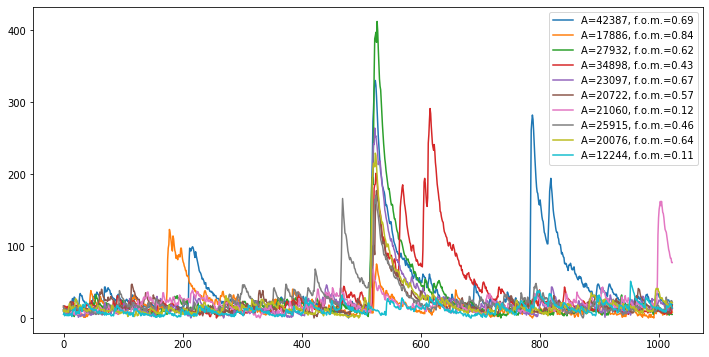

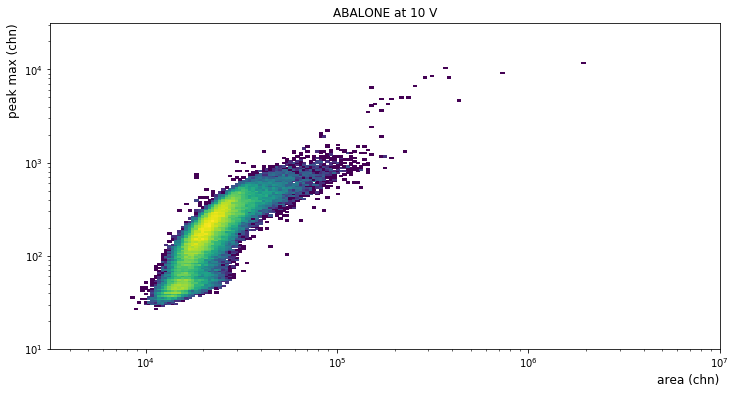

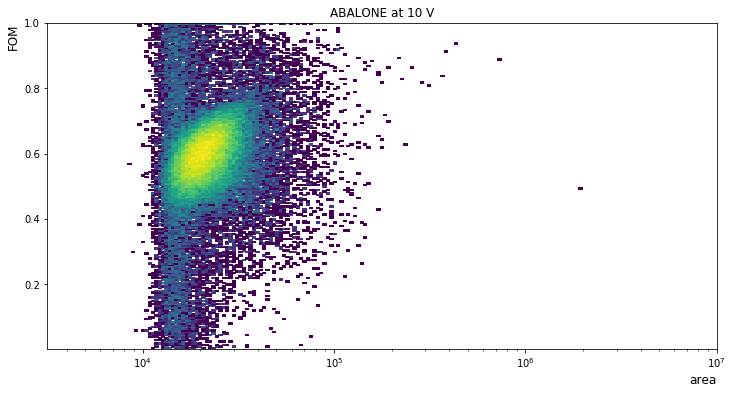

In [45]:
data_analysis(volts=10,filename='/data/abalone/2021_05_07/SiPM2_32V_ABALONE_10k_LED4V_h17.dat')

# ABALONE at 12 kV - 07/05/2021

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_12k_NoLED.dat Number of events 735537.0
Total events number: 735537
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.55
event n. 100000 time to process: 3.08
event n. 150000 time to process: 4.61
event n. 200000 time to process: 6.13
event n. 250000 time to process: 7.66
event n. 300000 time to process: 9.18
event n. 350000 time to process: 10.70
event n. 400000 time to process: 12.22
event n. 450000 time to process: 13.74
event n. 500000 time to process: 15.26
event n. 550000 time to process: 16.78
event n. 600000 time to process: 18.30
event n. 650000 time to process: 19.82
event n. 700000 time to process: 21.36


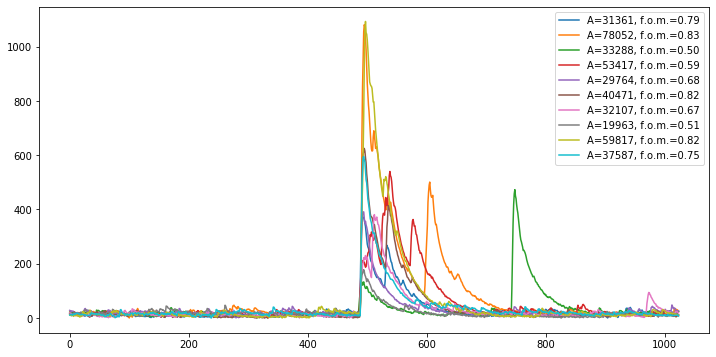

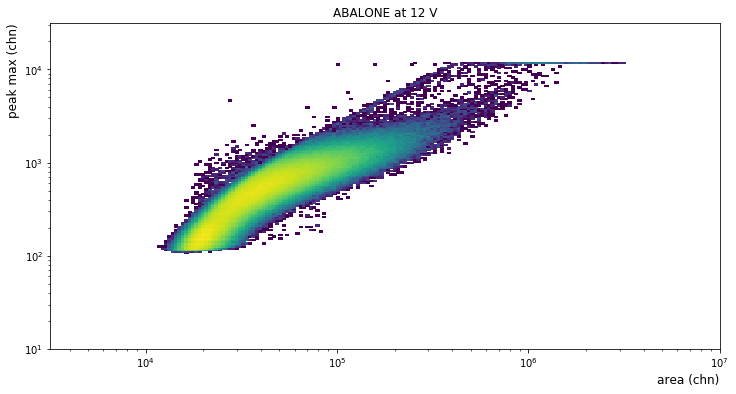

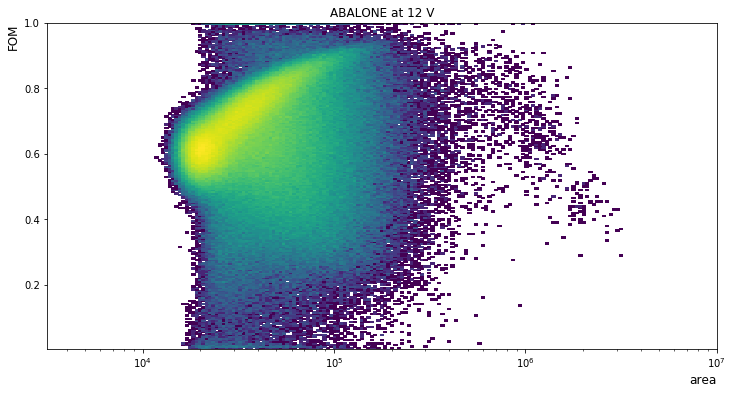

In [42]:
data_analysis(volts=12,filename='/data/abalone/2021_05_07/SiPM2_32V_ABALONE_12k_NoLED.dat')

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_12k_LED4V.dat Number of events 58820.0
Total events number: 58820
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.51


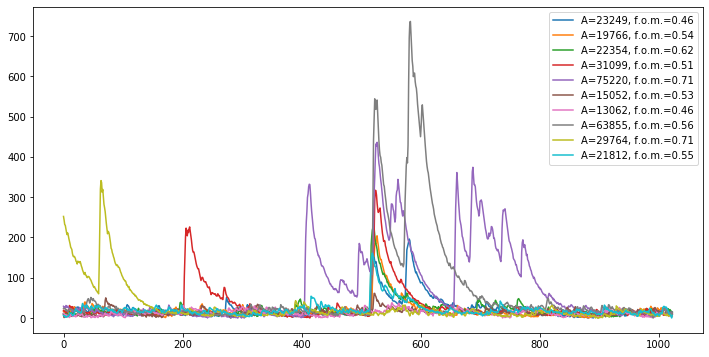

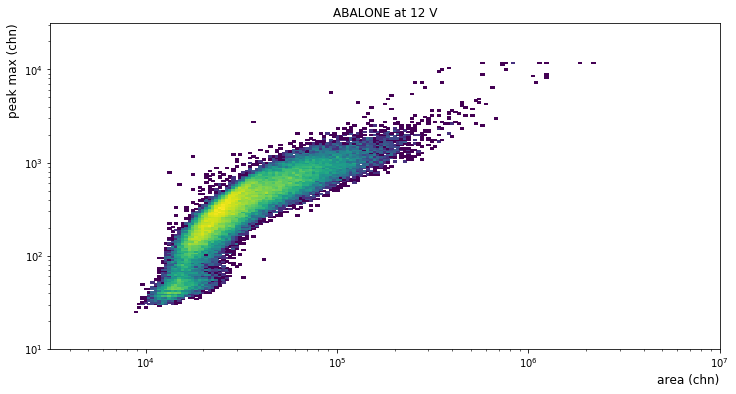

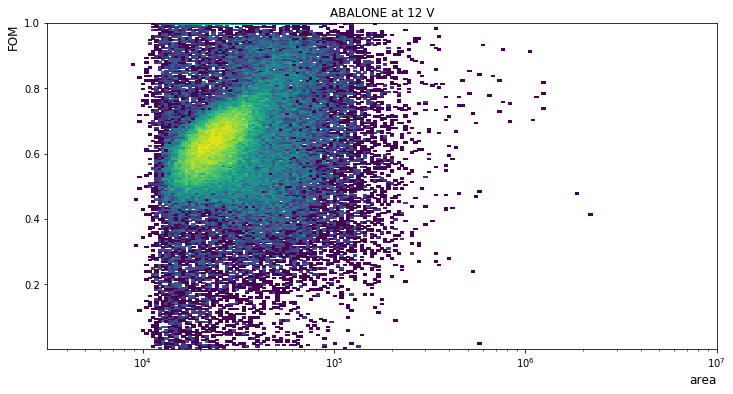

In [43]:
data_analysis(volts=12,filename='/data/abalone/2021_05_07/SiPM2_32V_ABALONE_12k_LED4V.dat')

# ABALONE at 13 kV - 07/05/2021

/data/abalone/2021_05_07/SiPM2_32V_ABALONE_13k_NoLED.dat Number of events 702801.0
Total events number: 702801
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.54
event n. 100000 time to process: 3.09
event n. 150000 time to process: 4.63
event n. 200000 time to process: 6.16
event n. 250000 time to process: 7.70
event n. 300000 time to process: 9.23
event n. 350000 time to process: 10.77
event n. 400000 time to process: 12.31
event n. 450000 time to process: 13.84
event n. 500000 time to process: 15.38
event n. 550000 time to process: 16.92
event n. 600000 time to process: 18.46
event n. 650000 time to process: 20.00
event n. 700000 time to process: 21.53
/data/abalone/2021_05_07/SiPM2_32V_ABALONE_13k_LED4V.dat Number of events 58419.0
Total events number: 58419
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.52


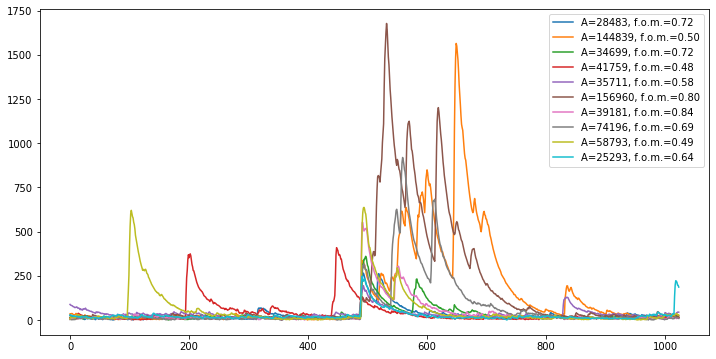

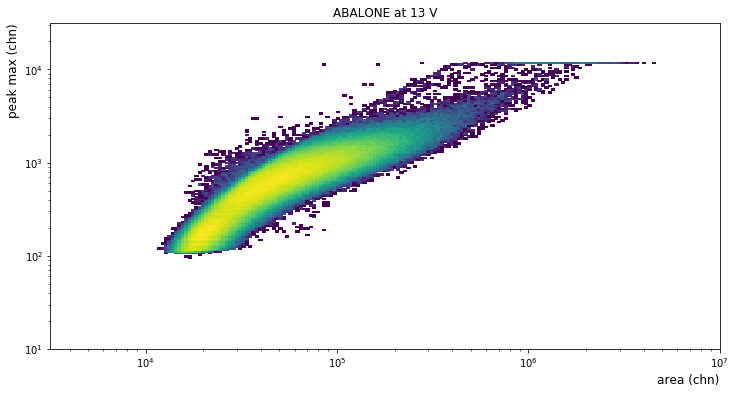

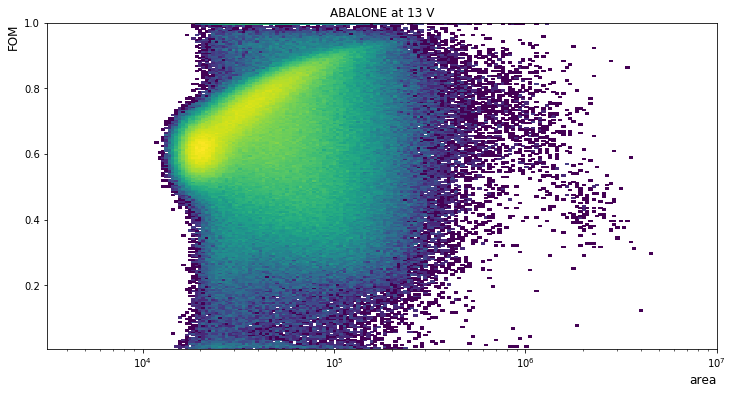

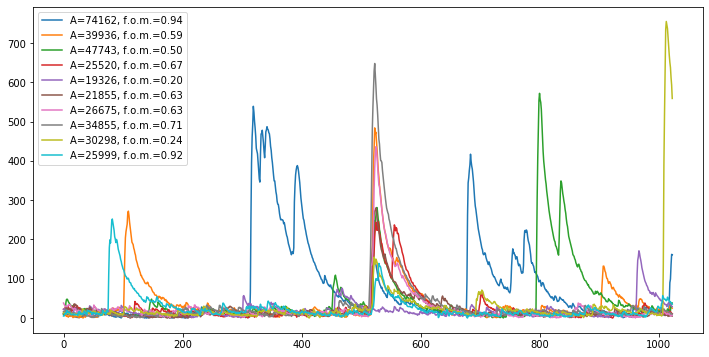

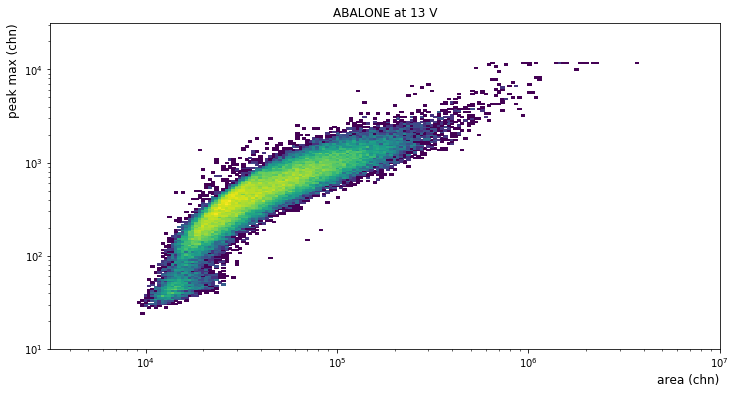

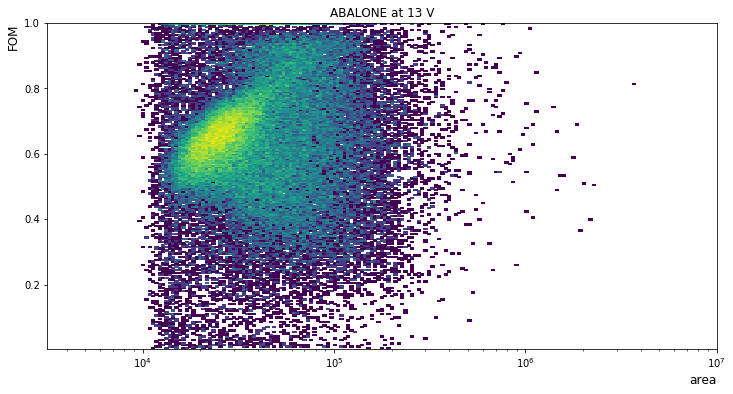

In [44]:
data_analysis(volts=13,filename='/data/abalone/2021_05_07/SiPM2_32V_ABALONE_13k_NoLED.dat')
data_analysis(volts=13,filename='/data/abalone/2021_05_07/SiPM2_32V_ABALONE_13k_LED4V.dat')

/data/abalone/2020_12_17/AbaloneJoern0_SiPM2_t70.dat Number of events 251629.0
Total events number: 251629
event n. 0 time to process: 0.00
event n. 50000 time to process: 1.52
event n. 100000 time to process: 3.02
event n. 150000 time to process: 4.52
event n. 200000 time to process: 6.01
event n. 250000 time to process: 7.52


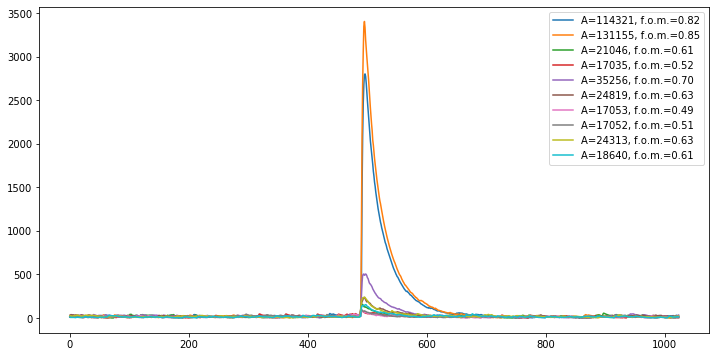

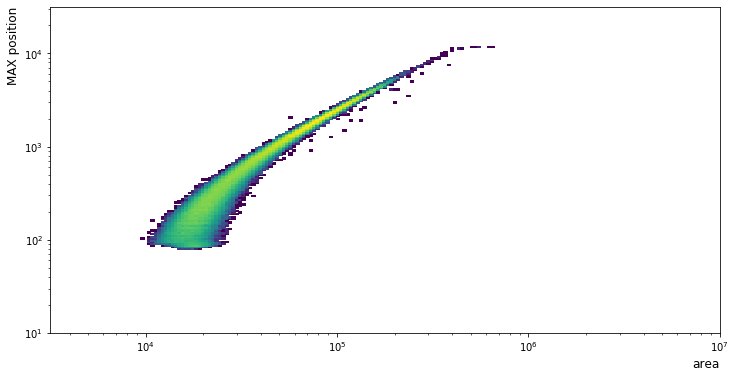

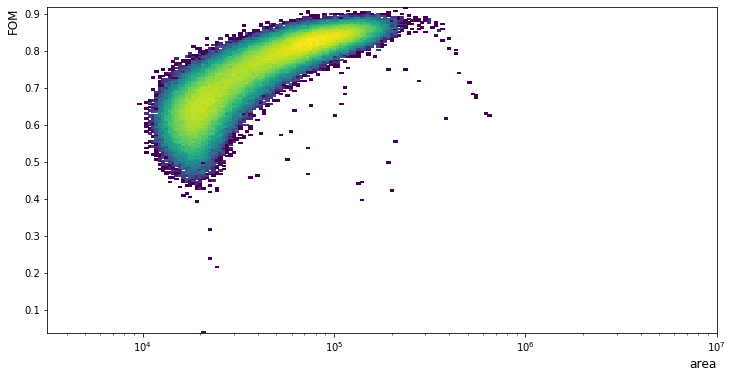

In [32]:
data_analysis(filename='/data/abalone/2020_12_17/AbaloneJoern0_SiPM2_t70.dat')

# ABALONE at 14 kV

/data/abalone/2021_05_10/SiPM2_32V_ABALONE_14k_NoLED.dat Number of events 765204.0
Total events number: 765204
event n. 0 time to process: 0.02
event n. 50000 time to process: 2.65
event n. 100000 time to process: 5.25
event n. 150000 time to process: 7.86
event n. 200000 time to process: 10.46
event n. 250000 time to process: 13.06
event n. 300000 time to process: 15.66
event n. 350000 time to process: 18.25
event n. 400000 time to process: 20.86
event n. 450000 time to process: 23.46
event n. 500000 time to process: 26.08
event n. 550000 time to process: 28.68
event n. 600000 time to process: 31.28
event n. 650000 time to process: 33.87
event n. 700000 time to process: 36.50
event n. 750000 time to process: 39.11


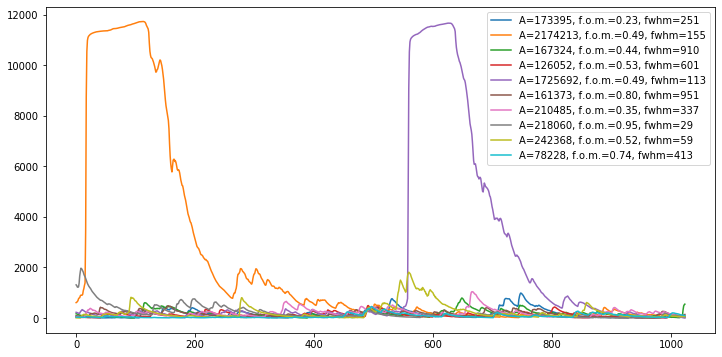

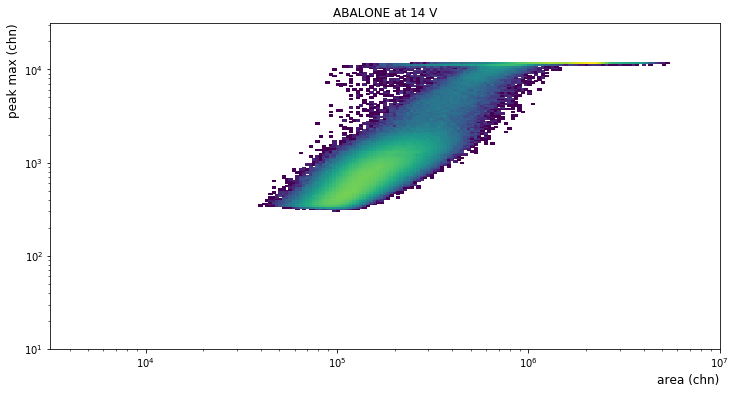

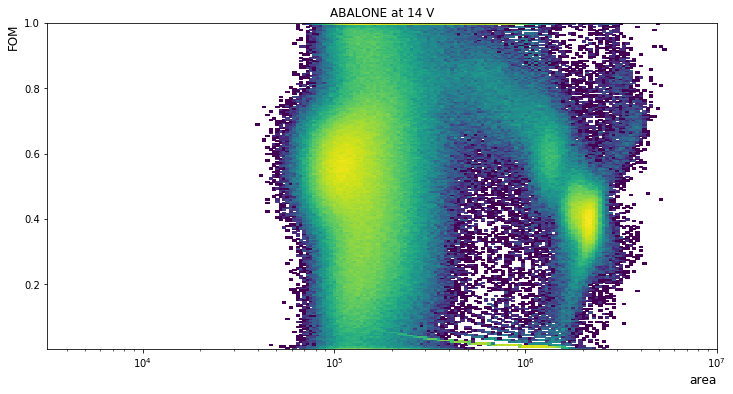

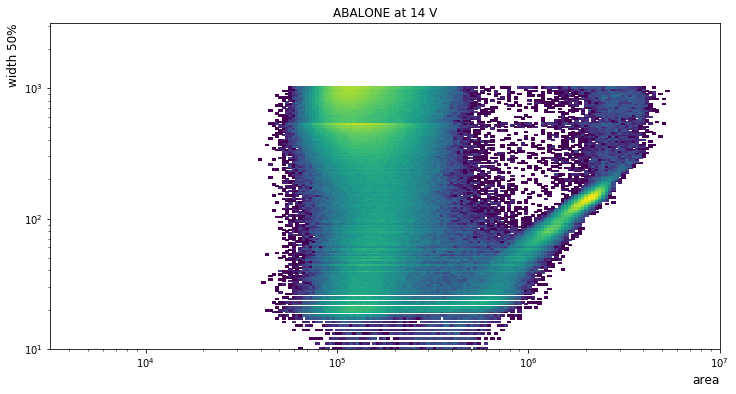

In [79]:
data_analysis(volts=14,filename='/data/abalone/2021_05_10/SiPM2_32V_ABALONE_14k_NoLED.dat')

/data/abalone/2021_05_10/SiPM2_32V_ABALONE_14k_LED4V.dat Number of events 57517.0
Total events number: 57517
event n. 0 time to process: 0.00
event n. 50000 time to process: 2.66


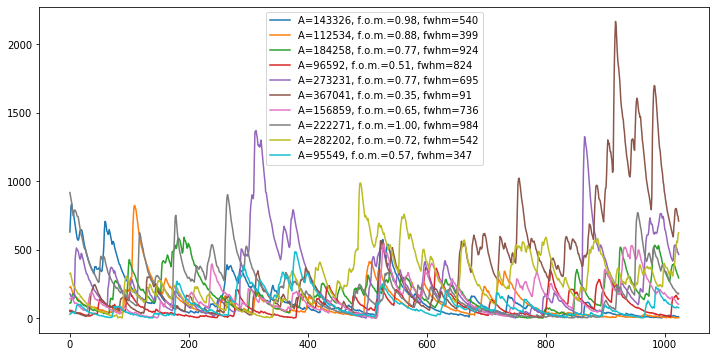

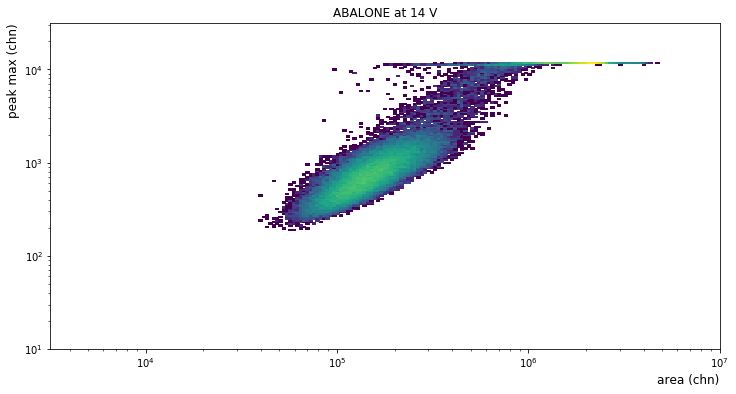

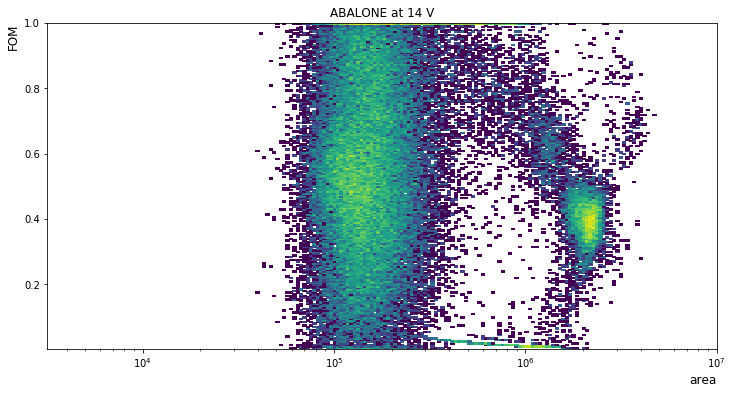

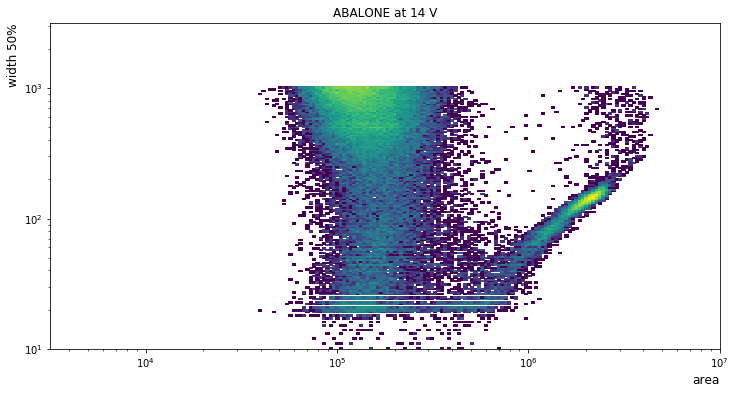

In [84]:
data_analysis(volts=14,filename='/data/abalone/2021_05_10/SiPM2_32V_ABALONE_14k_LED4V.dat')

/data/abalone/2021_05_10/SiPM2_32V_ABALONE_14k_NoLED_T1137.dat Number of events 604264.0
Total events number: 604264
event n. 0 time to process: 0.00
event n. 50000 time to process: 3.03
event n. 100000 time to process: 6.01
event n. 150000 time to process: 8.98
event n. 200000 time to process: 11.95
event n. 250000 time to process: 14.92
event n. 300000 time to process: 17.83
event n. 350000 time to process: 20.81
event n. 400000 time to process: 23.71
event n. 450000 time to process: 26.35
event n. 500000 time to process: 28.97
event n. 550000 time to process: 31.61
event n. 600000 time to process: 34.24


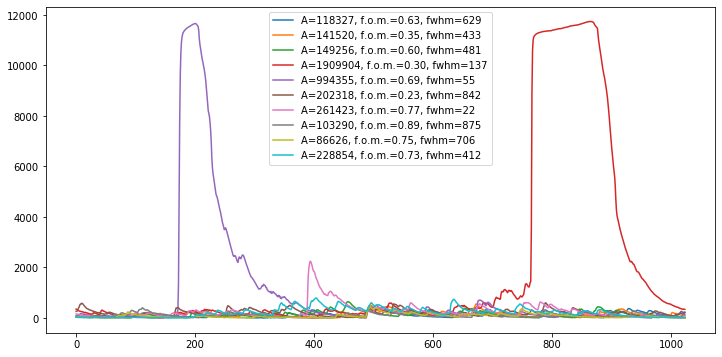

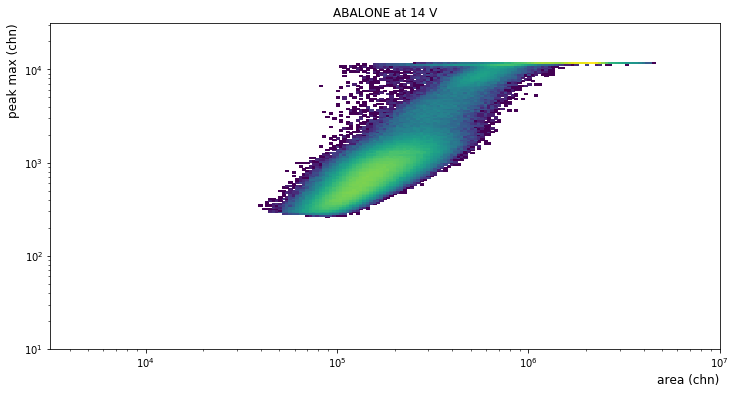

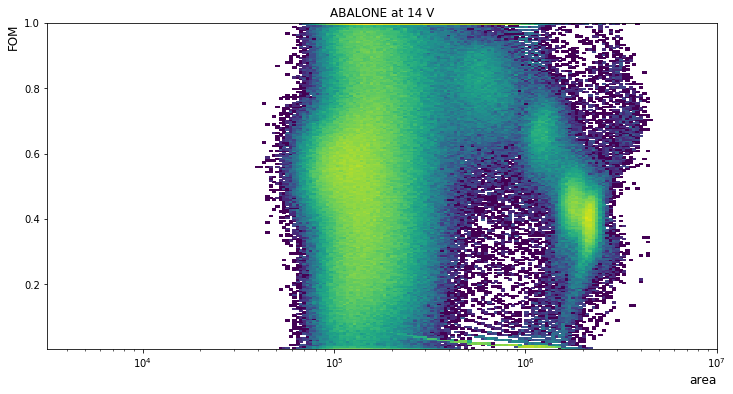

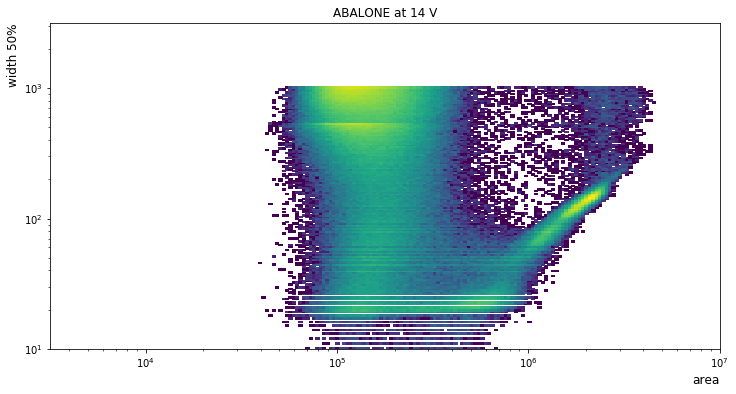

In [80]:
data_analysis(volts=14,filename='/data/abalone/2021_05_10/SiPM2_32V_ABALONE_14k_NoLED_T1137.dat')

/data/abalone/2021_05_10/SiPM2_32V_ABALONE_15k_NoLED_T1143.dat Number of events 313072.0
Total events number: 313072
event n. 0 time to process: 0.00
event n. 50000 time to process: 2.95
event n. 100000 time to process: 5.90
event n. 150000 time to process: 8.91
event n. 200000 time to process: 11.85
event n. 250000 time to process: 14.84
event n. 300000 time to process: 17.82


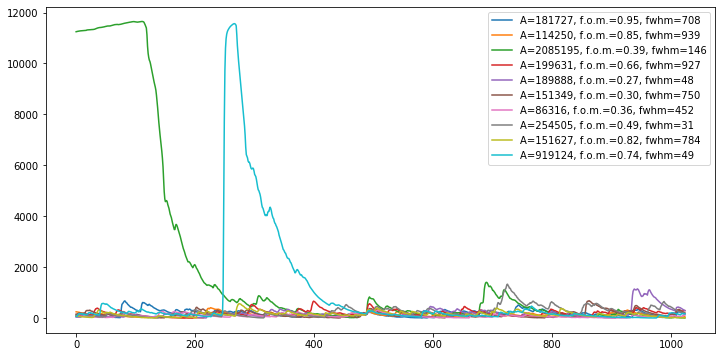

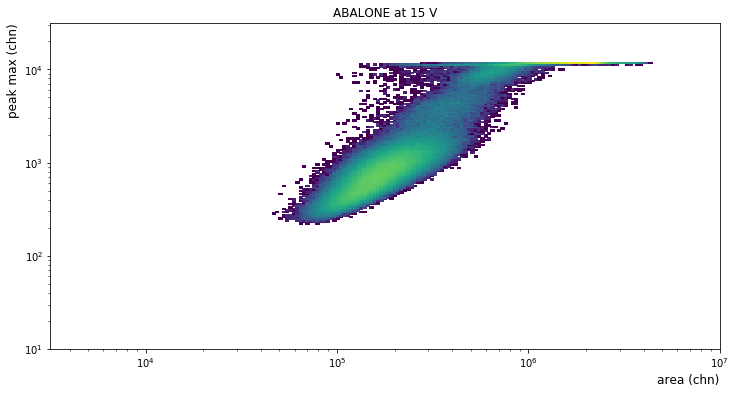

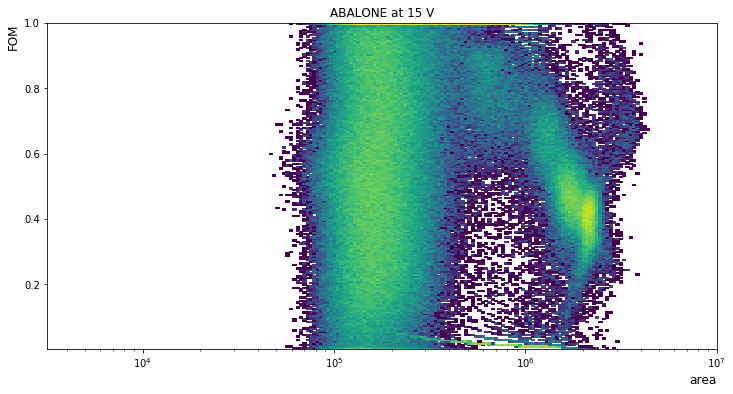

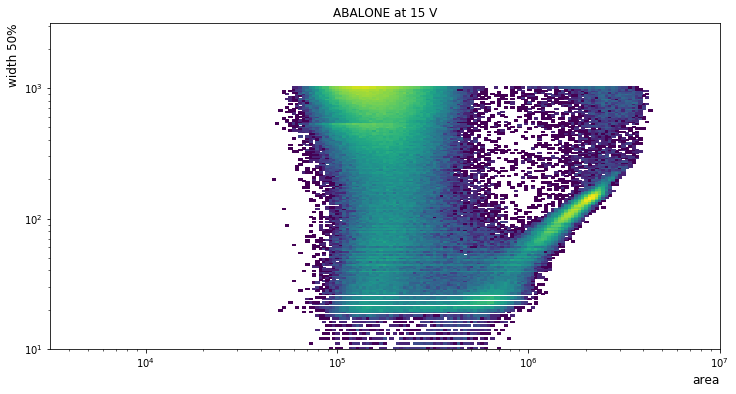

In [82]:
data_analysis(volts=15,filename='/data/abalone/2021_05_10/SiPM2_32V_ABALONE_15k_NoLED_T1143.dat')

/data/abalone/2021_05_10/SiPM2_32V_ABALONE_15k_LED4V_T1146.dat Number of events 57876.0
Total events number: 57876
event n. 0 time to process: 0.00
event n. 50000 time to process: 2.63


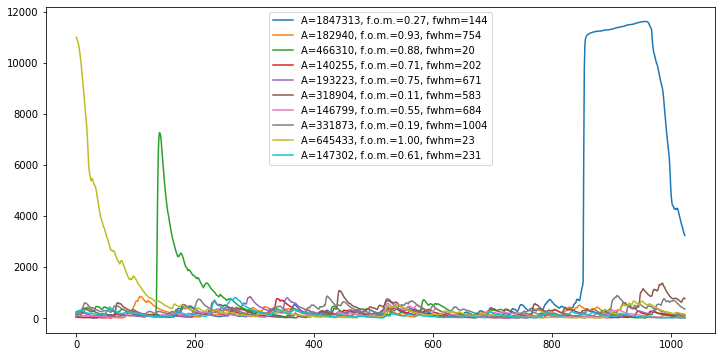

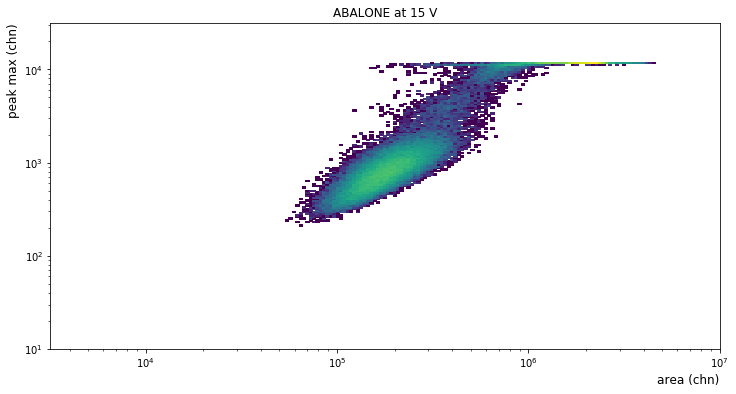

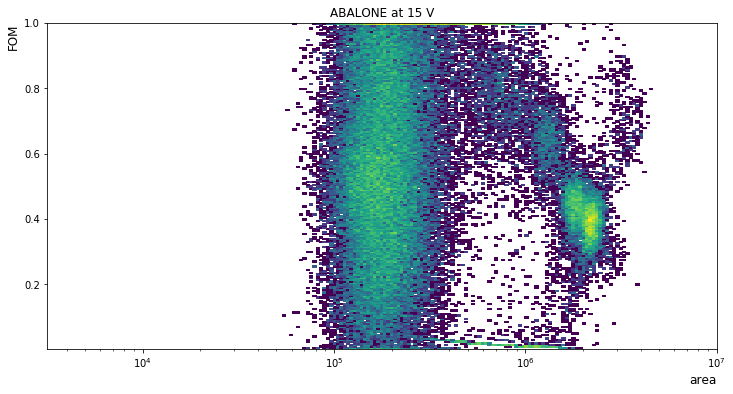

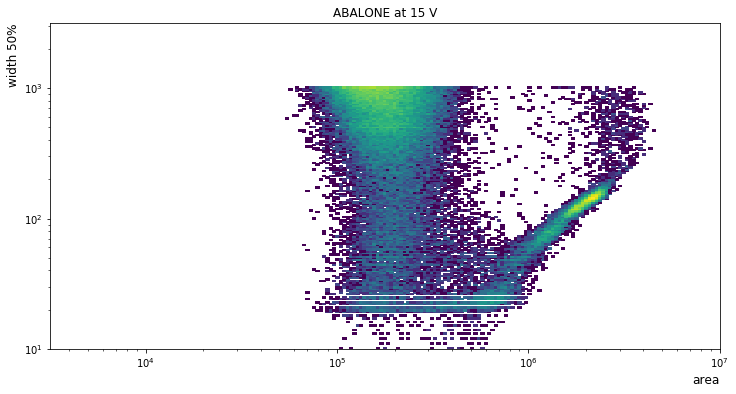

In [83]:
data_analysis(volts=15,filename='/data/abalone/2021_05_10/SiPM2_32V_ABALONE_15k_LED4V_T1146.dat')